# K-Means, DBSCAN, and Hierarchical Clustering in Python using Record Data (REKT API)

## Introduction

For clustering, we shall drop the target variable (Y) of scam_type_grouped, which will leave us with our feature data (X) to cluster with. Moreover, we will need to filter out the categorical features, including scam_networks, month_of_attack, and day_of_week_of_attack, from our feature data to accurately perform clustering using only numeric record features. The feature data (X) that we will eventually be left with will contain 3 record features, including two features for log of funds (lost and returned) and one datetime extracted feature of day_of_year_of_attack. 

I did debate with myself to include month_of_attack and day_of_week_of_attack variables for clustering, but since we already have day_of_year_of_attack, it can convey the information of both month_of_attack and day_of_week_of_attack. At the end of the analysis, we will use the target variable (Y) of scam_type_grouped to check if the clustering predictions coincided with the existing labels in the data-set, which will be our goal.


## Theory

#### K-Means Clustering

K-Means Clustering is a centroid or distance-based algorithm with each cluster of our data points containing a centroid or cluster center. It is also a non-parametric clustering algorithm, which means that it does **not** make strong assumptions about the form of the mapping function that maps input variables (X) to output variables (Y). The objective of this algorithm is to minimize the sum of squared distances between data points and their respective cluster centroid. To understand better, we can break down the algorithm into 5 steps as follows:
1. Choose "k" clusters
2. Select "k" random points from the feature data (X) as centroids 
3. Assign remaining datapoints to the closest cluster centroid
4. Recompute centroids of newly formed clusters 
5. Repeat steps 3 and 4

The stopping criteria is when:
1. Centroids of newly formed clusters don't change (convergence)
2. Data points remain in the same cluster
3. Maximum number of iterations are reached

To measure the "closeness" of data points with their respective cluster, we measure similarity between the data points using Euclidean Distance (Distance = $\sqrt{(x_1 - y_1)^2+(x_2 - y_2)^2+...+(x_n - y_n)^2}$)

The model selection methods to use will include the elbow method to select the optimal value for "k" number of clusters. This selection technique relies on two metrics, Distortion and Inertia. Distortion is calculated as the average of the squared distances from the cluster centers of the respective clusters, using Euclidean distance. Inertia is the sum of squared distances of samples to their closest cluster center. After visualizing the distortion and inertia values for different values of "k", we can determine the optimal number of clusters by selecting the value of k at the “elbow” of the curve, which is the point after which the distortion/inertia start decreasing in a linear fashion or when they start decreasing slowly. A good model is one with low inertia AND a low number of clusters (K). However, a tradeoff exists because as K increases, inertia decreases. I shall also employ the Silhouette score on the entire feature data (X), including categorical variables, as well as on only the numerical variables, log_funds_lost and log_funds_returned, to better visualize the clusters.

K-Means clustering does have its limitations, the main drawback that it is sensitive to poor initializiation of clusters, which could lead to the algorithm being stuck in a local optimum space. Moreover, the shape and size of clusters could differ with each other, resulting in larger distances among points. Yet, K-Means is interpretable, efficient, guarantees an approximation, and works well for clusters having similar properties (size, shape, and density).

#### DBSCAN (Density-based Spatial Clustering of Applications with Noise)

DBSCAN is a density-based clustering method that is useful when the clusters are irregular or non-spherical, for example, or when noise and outliers are present in the feature data (X). Given a set of points in some space, it groups together points that are closely packed together (points with many nearby neighbors). Outliers are marked as points that lie alone in low-density regions, whose nearest neighbors are too far away. To understand better, DBSCAN works in the following 3 steps:
1. The algorithm proceeds by arbitrarily picking up a point in the dataset (until all points have been visited).
2. If there are at least minimum number of points (a threshold) clustered together for a region to be considered dense, within a radius of $\epsilon$ (a distance measure used to locate the points in the neighborhood of any point) to the point, then we consider all these points to be part of the same cluster. These minimum number of points, known as minPts, is one parameter for DBSCAN and $\epsilon$ is another parameter.
3. The clusters are then expanded by recursively repeating the neighborhood calculation for each neighboring point.

If minPts = 1, then every point on its own will already be a cluster, which in infeasible. If minPts $\leq$ 2, the result will be the same as of hierarchical clustering, with the dendrogram cut at height $\epsilon$. Therefore, minPts must be $\geq$ 3. However, larger values for minPts are usually better for data sets with noise as DBSCAN will then yield more significant clusters.

The model selection method to use will include the Silhouette score to select the optimal DBSCAN hyper-parameters. The Silhouette score takes values between -1 to 1, with -1 being the worst value and 1 denoting that the data point i is very compact within the cluster to which it belongs and far away from the other clusters. Values near 0 denote points are on or very close to the decision boundary between two neighboring clusters, leading to overlapping clusters.

DBSCAN can locate non-linearly separable clusters but K-Means cannot. Moreover, unlike K-Means, there is no need to specify the number of clusters "k" when employing DBSCAN. However, choosing a value for $\epsilon$ is more difficult than choosing a good initial value for "k" for K-Means because $\epsilon$ is less intuitive to reason.

#### Hierarchical (Agglomerative vs Divisive) Clustering

Hierarchical clustering technique is different from Partitional clustering, which divides the data into non-overlapping clusters such that each data point belongs to exactly one cluster. Hierarchical clustering can be thought of a set of nested clusters organized as a hierarchical tree, visualized through dendrograms. There exist two main types of hierarchical clustering: 
1. Agglomerative clustering (bottom up): Start with the points as individual clusters. At each step, move up the hierarchy by merging the closest pair of clusters until only one cluster is left. 
2. Divisive clustering (top down): All observations start in one, all-inclusive cluster. At each step, move down the hierarchy by splitting a cluster recursively until each cluster contains a point. Therefore, this approach is exactly opposite to Agglomerative clustering.

Hierarchical clustering's process can be visualized with the help of a dendrograma, a type of tree diagram showing hierarchical relationships between different sets of data. The dendrogram can be used to decide when to stop merging the clusters or, in other words, finding the optimal number of clusters. We cut the dendrogram tree with a horizontal line at a height where the line can traverse the maximum distance up and down without intersecting the merging point.

Hierarchical clustering, unlike K-Means, does not require initializing the number of clusters apriori, which is a benefit. Moreover, the dendrograms generated by Hierarchical clustering can be more informative than the spherical clusters returned by K-Means. However, Hierarchical clustering can be sensitive to outliers and computationally inefficient when working with large datasets.


## Methods

### Data Selection

In [286]:
# import the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
import sklearn.cluster as cluster
sns.set_theme(style="whitegrid", palette='Set2')
import warnings
warnings.filterwarnings("ignore")

# read in cleaned REKT Database and drop labels and other variables, leaving only feature data (X)

df = pd.read_csv("../../data/Clean Data/REKT_Database_Clean_Classification.csv", index_col=[0])
df_cluster = df.drop(['scam_type_grouped', 'day_of_week_of_attack', 'day_of_year_of_attack'], axis=1)
df_cluster.head() # visualize first 5 rows

,log_funds_lost,log_funds_returned,scamNetworks,month_of_attack
1,5.799093,0.000000,Ethereum,11
2,15.201805,0.000000,Ethereum,9
3,12.088825,0.000000,Ethereum,8
4,17.179352,16.754673,Binance,10
5,11.338096,0.000000,Binance,2


In [287]:
df_cluster.shape # get the number of rows and columns

(816, 4)

In [288]:
print(df_cluster.info()) # get column information

<class 'pandas.core.frame.DataFrame'>
Int64Index: 816 entries, 1 to 816
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   log_funds_lost      816 non-null    float64
 1   log_funds_returned  816 non-null    float64
 2   scamNetworks        816 non-null    object 
 3   month_of_attack     816 non-null    int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 31.9+ KB
None


In [289]:
df_cluster.isnull().sum() # check for missing values

log_funds_lost        0
log_funds_returned    0
scamNetworks          0
month_of_attack       0
dtype: int64

### Feature selection and Pre-processing

As shown in the code above, we not only dropped the target variable, scam_type_grouped, but also two datetime extracted features, day_of_week_of_attack and day_of_year_of_attack. Dr. Nakul's inputs and my EDA helped me choose between the datetime variables, which led me to only choose month_of_attack as a categorical variable. Recalling from the EDA section, the month of attack conveyed that most attacks took place between August and September, with other attacks taking place roughly at the same frequency in all other months. Therefore, we can expect clusters around certain months.

In terms of pre-processing our data, our funds variables are already log-transformed and, if we recall from the EDA section, we obtained a fairly normal distribution for both log funds variables. The only pre-processing left to be done is on the categorical variable, scamNetworks, which represents the unique cryptocurrency token associated with the attack. We will use ```cat.codes``` to encode the categorical variable. Therefore, we do not need to run any scaling methods, such as sklearn's ```StandardScaler```, on our feature data.

In [290]:
# Replace categorical values with category codes by using the cat.codes function. you can either replace them in place or create a new column. show the altered dataframe again by using head() 
df_cluster['scamNetworks'].value_counts()
df_cluster['scamNetworks'] = df['scamNetworks'].astype('category').cat.codes 

df_cluster.head()

,log_funds_lost,log_funds_returned,scamNetworks,month_of_attack
1,5.799093,0.000000,8,11
2,15.201805,0.000000,8,9
3,12.088825,0.000000,8,8
4,17.179352,16.754673,3,10
5,11.338096,0.000000,3,2


### Seperate the dataset into features and labels

In [291]:
# Split the dataset in X and y. since this is unsupervised learning, we will not use the y labels.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 

X = df_cluster
y = df['scam_type_grouped']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform K-means Clustering

In [292]:
# import relevent libraries for clustering
from statistics import mode
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import accuracy_score

In [293]:
# for k means clustering we will use the elbow method to find the optimal number of clusters. 
# we will use the inertia_ attribute to find the sum of squared distances of samples to their closest cluster center. 
# we will use the range of 1 to 20 clusters and plot the inertia_ values for each cluster. 
distortions = []
inertias = []
k = 16

for k in range(1,k):
    kmeansmodel = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeansmodel.fit(X)

    distortions.append(sum(np.min(cdist(X, kmeansmodel.cluster_centers_, 'euclidean'), axis=1))/ X.shape[0])
    inertias.append(kmeansmodel.inertia_)
    evaluation=pd.DataFrame.from_records({"Cluster":np.arange(1,k+1), "Distortion":distortions, "Inertia":inertias})

evaluation

,Cluster,Distortion,Inertia
0,1,6.879449,50397.468473
1,2,5.942030,35167.440519
2,3,5.040738,23742.921023
3,4,4.213937,16987.199503
4,5,3.712076,14141.902712
5,6,3.382176,12244.501253
6,7,3.250917,10669.074143
7,8,2.945783,9195.375448
8,9,2.786022,8360.709570
9,10,2.635544,7653.398571


array([<AxesSubplot:xlabel='Cluster'>, <AxesSubplot:xlabel='Cluster'>],
      dtype=object)

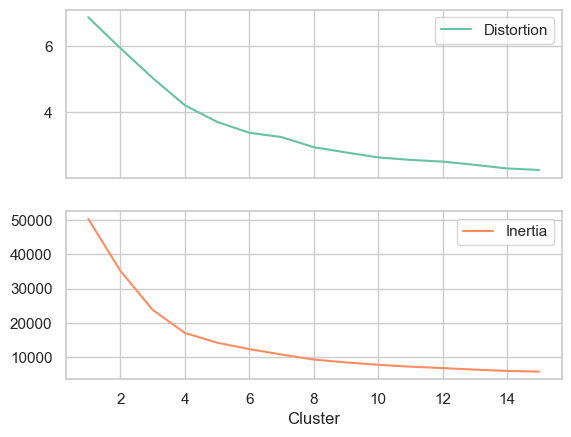

In [294]:
# plot distortion and inertia for kmeans, you can either plot them seperately or use fig, ax = plt.subplots(1, 2) to plot them in the same figure. Suggest the optimal number of clusters based on the plot.
evaluation.plot.line(x="Cluster", subplots=True)

[Text(0.5, 1.0, 'K-Means Clustering Plot')]

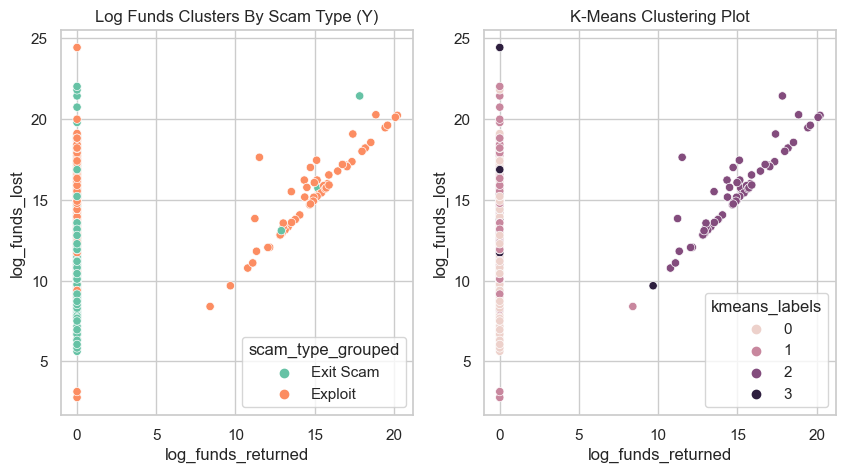

In [295]:
# Plotting clusters for best k = 4 (as per elbow method above)

bestK = KMeans(n_clusters=4, init='k-means++', random_state=42)
labels4 = bestK.fit_predict(X)
df['kmeans_labels'] = labels4

fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.scatterplot(x="log_funds_returned", y="log_funds_lost", hue="scam_type_grouped", data=df, ax=ax[0]).set(title='Log Funds Clusters By Scam Type (Y)')
sns.scatterplot(x="log_funds_returned", y="log_funds_lost", hue="kmeans_labels", data=df, ax=ax[1]).set(title='K-Means Clustering Plot')


According to the distortion and intertia values across the 15 clusters, the initial K-Means model conveys that k=4 clusters is the optimal number of clusters to use. The scatterplots above provide a binary representation of the two continuous features, log_funds_lost and log_funds_returned, of our feature data (X) to visualize the labels generated by the K-Means model with n_clusters set to 4. Next, we shall explore how the silhouette scores of the K-Means clusters affects our conclusions about this model.

### Hyper-parameter tuning

OPTIMAL PARAMETER = 3


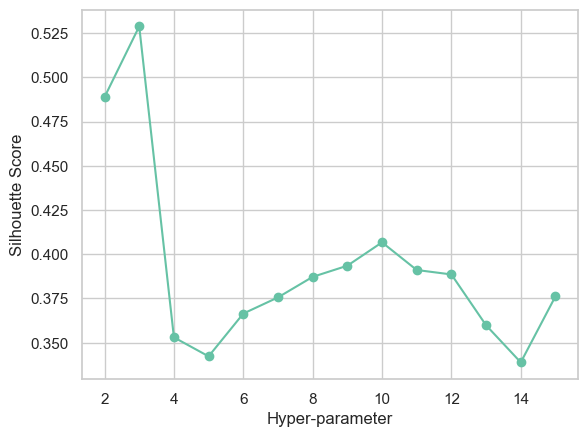

In [296]:
# THIS WILL ITERATE OVER ONE HYPER-PARAMETER (GRID SEARCH) 
# AND RETURN THE CLUSTER RESULT THAT OPTIMIZES THE SILHOUETTE SCORE
import sklearn.cluster

def maximize_silhouette(X,algo="birch",nmax=20,i_plot=False):

    # PARAM
    i_print=False

    #FORCE CONTIGUOUS
    X=np.ascontiguousarray(X) 

    # LOOP OVER HYPER-PARAM
    params=[]; sil_scores=[]
    sil_max=-10
    for param in range(2,nmax+1):
        if(algo=="kmeans"):
            model = sklearn.cluster.KMeans(n_clusters=param).fit(X)
            labels=model.predict(X)

        try:
            sil_scores.append(sklearn.metrics.silhouette_score(X,labels))
            params.append(param)
        except:
            continue 

        if(i_print): print(param,sil_scores[-1])
        
        if(sil_scores[-1]>sil_max):
             opt_param=param
             sil_max=sil_scores[-1]
             opt_labels=labels

    print("OPTIMAL PARAMETER =",opt_param)

    if(i_plot):
        fig, ax = plt.subplots()
        ax.plot(params, sil_scores, "-o")  
        ax.set(xlabel='Hyper-parameter', ylabel='Silhouette Score')
        plt.show()

    return opt_labels

k_means_opt_labels=maximize_silhouette(X,algo="kmeans",nmax=15, i_plot=True)

When n_clusters=3, the silhouette score is maximized on our entire feature data (X), including both continuous features of log of funds and the two categorical features of scamNetworks and month of attack. This result differs from that of the elbow method, which conveyed that n_clusters=4 clusters was the optimal solution. The elbow method is used to find the “elbow” point, where adding additional data samples does not change cluster membership much. The Silhouette score determines whether there are large gaps between each sample and all other samples within the same cluster or across different clusters. The major difference between elbow and silhouette scores is that elbow only calculates the euclidean distance whereas silhouette takes into account variables such as variance, skewness, high-low differences, etc. Therefore, both hyper-parameter tuning methods convey different use cases and probably silhouette score can be given more weightage when considering the optimal number of clusters for K-Means.

Next, we will subset only the continuous features, log_funds_returned and log_funds_lost, and run K-Means on only these two features to easily visualize the silhouette score hyper-parameter tuning:

For n_clusters = 2 The average silhouette_score is : 0.7836417135554179
For n_clusters = 3 The average silhouette_score is : 0.5641864790603397
For n_clusters = 4 The average silhouette_score is : 0.5458670160810305
For n_clusters = 5 The average silhouette_score is : 0.5440487943472511


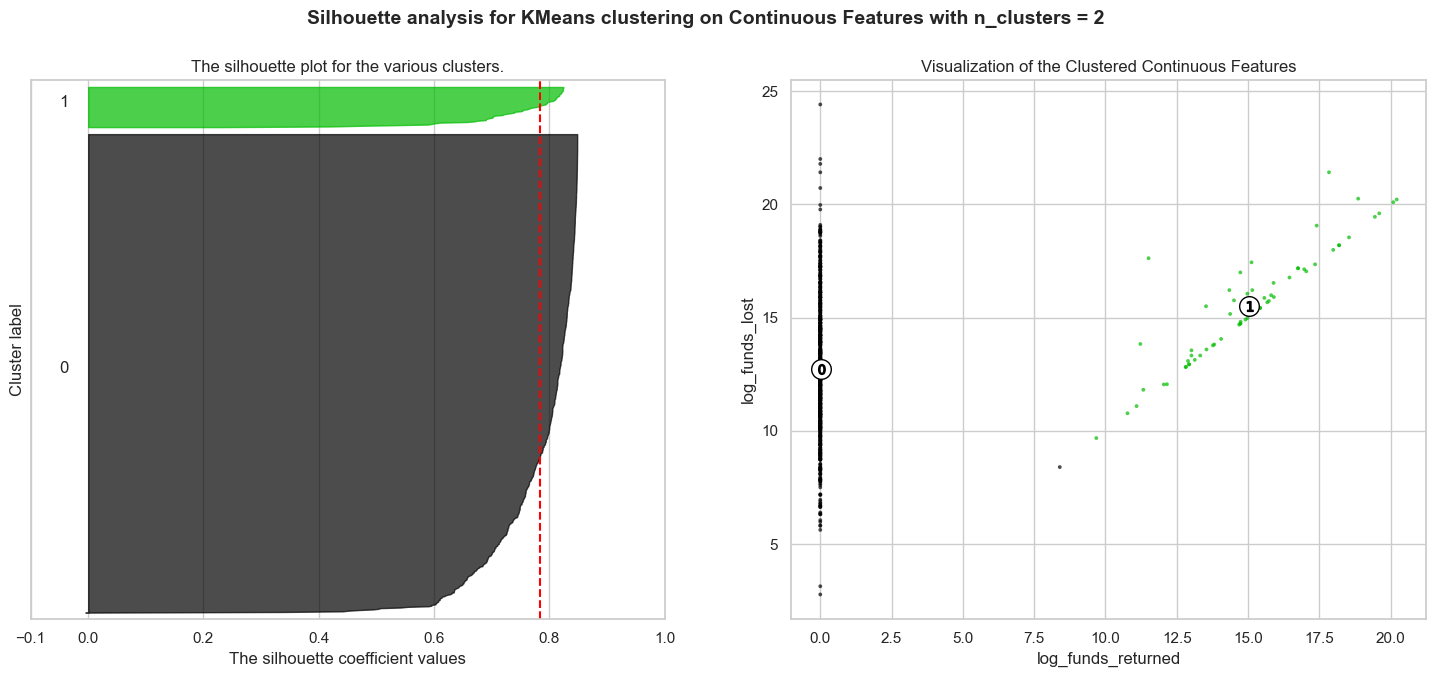

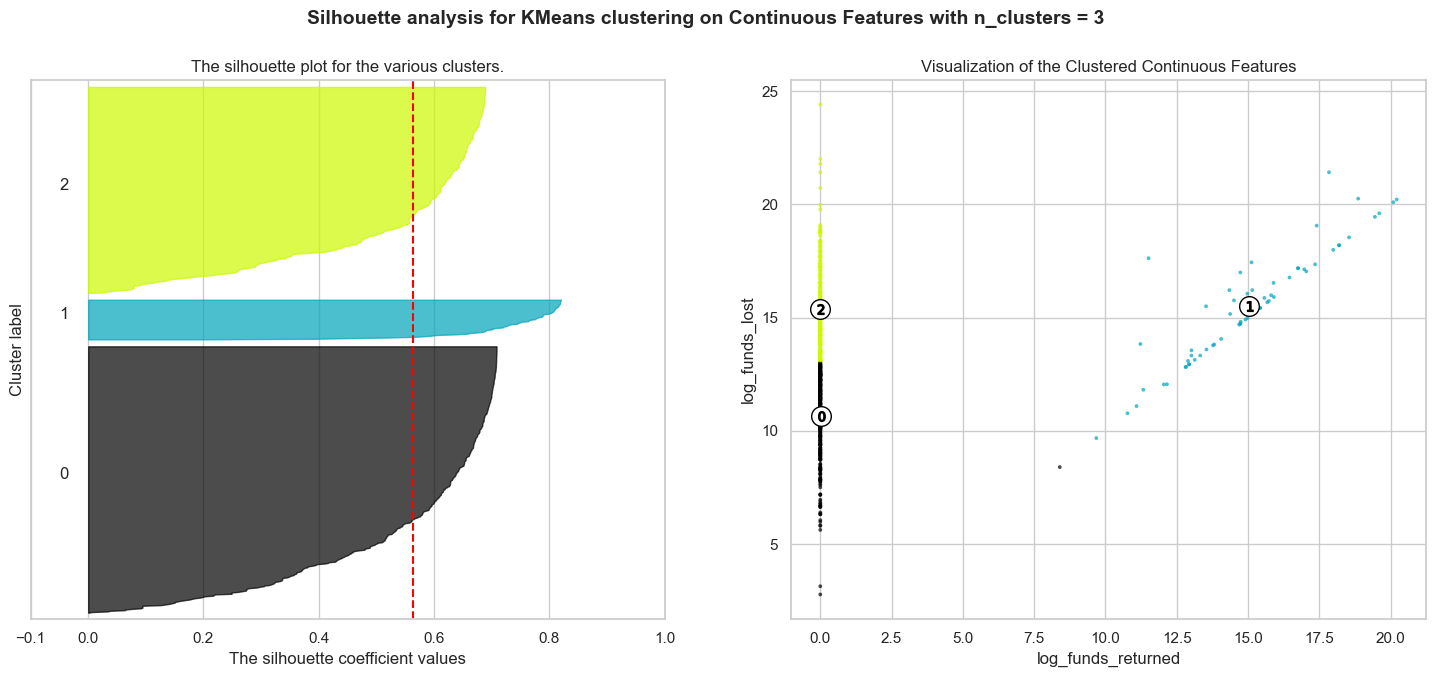

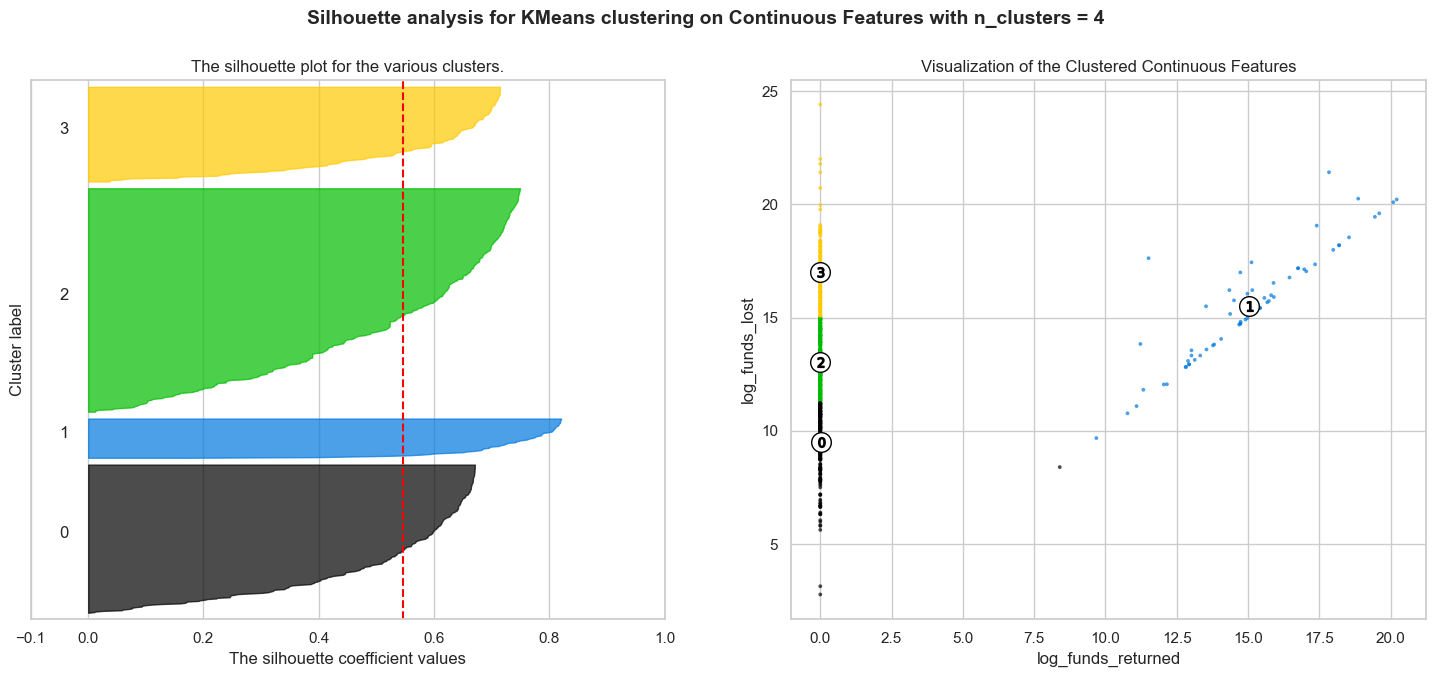

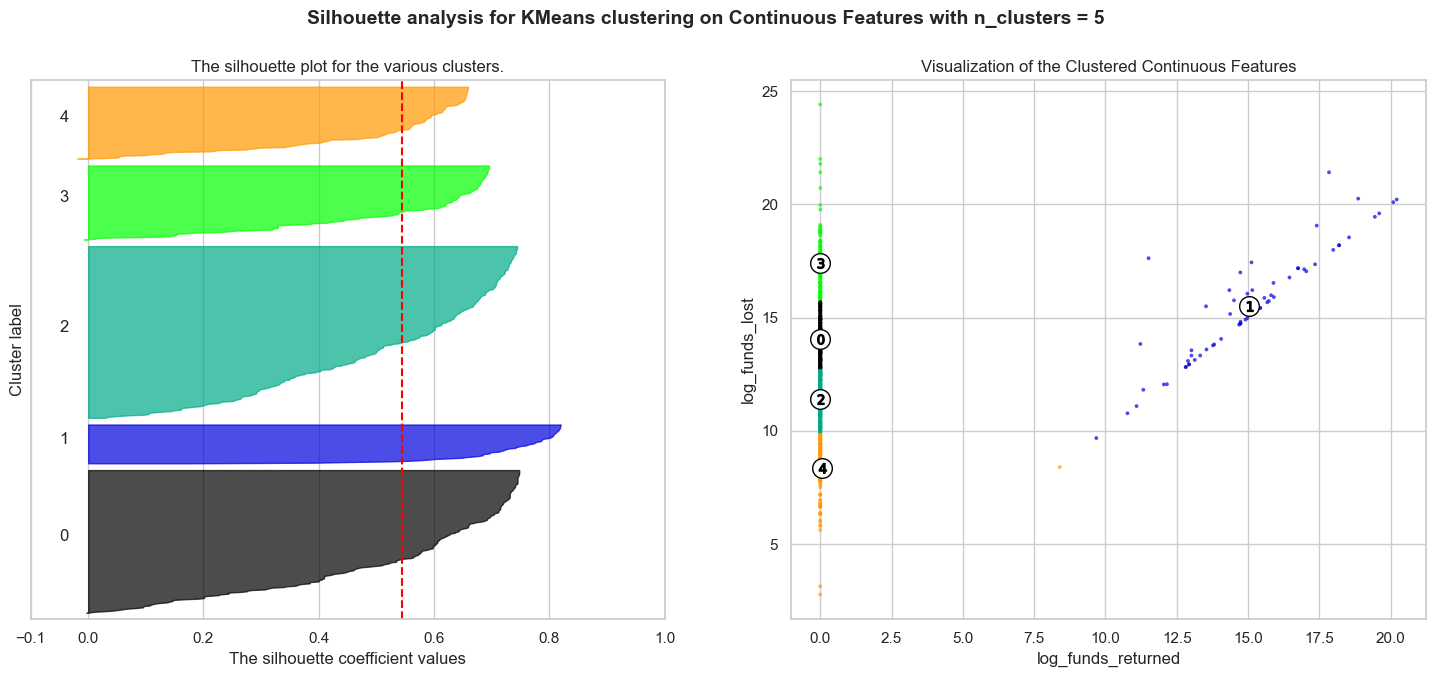

In [297]:
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm

X = X[["log_funds_returned", "log_funds_lost"]] # subset only the continuous features for visualization

range_n_clusters = [2, 3, 4, 5]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X['log_funds_returned'], X['log_funds_lost'], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("Visualization of the Clustered Continuous Features")
    ax2.set_xlabel("log_funds_returned")
    ax2.set_ylabel("log_funds_lost")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on Continuous Features with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

Silhouette plots look to have an edge over elbow method as one can evaluate clusters on multiple criteria, including scores below average Silhouette score (red vertical line), wide fluctuations in the size of the plot, and non-uniform thickness. Therefore, it is highly likely that one can end up determining the most optimal number of clusters in K-means using the above plots. 

All n_clusters, 2 to 5, have scores above the average Silhouette score (red vertical line), which means we are down to checking thickness fluctuations of the plots. When n_clusters=2, although the silhouette score is maximized, the thickness of the silhouette plots suggests that the cluster sizes are highly different or non-uniform. Our aim is to choose those n_clusters that correspond to uniform thickness of the clusters’ Silhouette plot.

When n_clusters=3, the silhouette score is lower than that of n_clusters=2, but the thickness of the silhouette plots is still non-uniform. However when n_clusters is equal to 4, all the plots are more or less of similar thickness and, hence, are of similar sizes as can be also verified from the labelled scatter plot on the right. Again, these plots are generated on only continuous features and are used as reference for visualization purposes.

### Final results for k-Means Clustering

When clustering our entire feature data (X), we choose k=3 as the optimal parameter for K-Means as per the elbow method, the silhouette scores, and silhouette plots. However, when we subset our feature data for only continuous features, then k=3 is the optimal parameter as per highest silhouette score. The code below is our final result for K-Means clustering on the entire feature data (X), with a visualization of the 3 different clusters using only continuous features (since visualizing 4 dimensions is infeasible).

[Text(0.5, 1.0, 'Final K-Means Clustering Plot')]

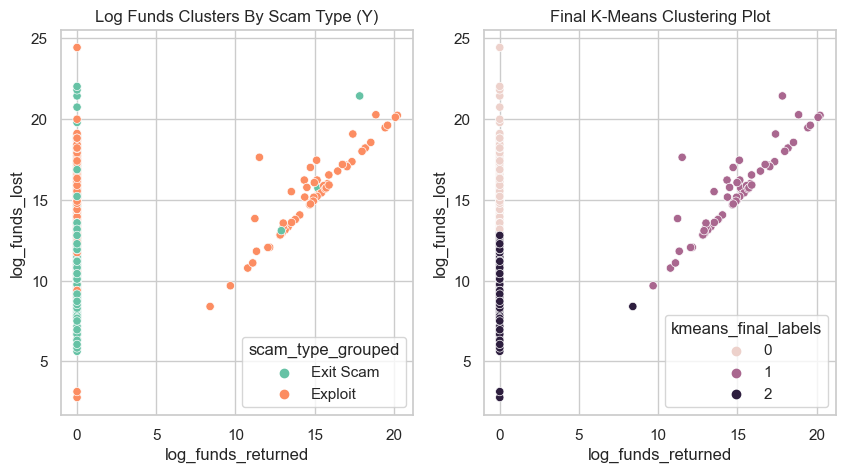

In [298]:
# Plotting clusters for best k = 3 (as per silhouette method)

bestK = KMeans(n_clusters=3, init='k-means++', random_state=42)
kmeans_labels_final = bestK.fit_predict(X)
df['kmeans_final_labels'] = kmeans_labels_final

fig, ax = plt.subplots(1,2,figsize=(10,5))
sns.scatterplot(x="log_funds_returned", y="log_funds_lost", hue="scam_type_grouped", data=df, ax=ax[0]).set(title='Log Funds Clusters By Scam Type (Y)')
sns.scatterplot(x="log_funds_returned", y="log_funds_lost", hue="kmeans_final_labels", data=df, ax=ax[1]).set(title='Final K-Means Clustering Plot')


# Perform DBSCAN 

In [299]:
# perform DBSCAN clustering. use the eps and min_samples parameters to find the optimal number of clusters. plot the number of clusters vs the silhouette score. Suggest the optimal number of clusters based on the plot.
from sklearn.cluster import DBSCAN

X = df_cluster
model = DBSCAN(eps=0.5, min_samples=5) 
model.fit(X)
y_pred = model.fit_predict(X)
labels_DB = model.labels_
#print(labels_DB)

[Text(0.5, 1.0, 'DBSCAN Clustering Plot')]

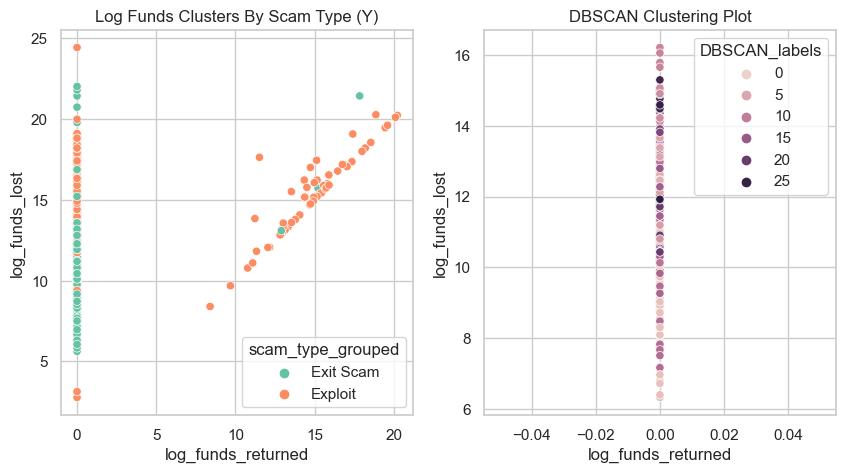

In [300]:
df['DBSCAN_labels'] = labels_DB

fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.scatterplot(x="log_funds_returned", y="log_funds_lost", hue="scam_type_grouped", data=df, ax=ax[0]).set(title='Log Funds Clusters By Scam Type (Y)')
sns.scatterplot(x="log_funds_returned", y="log_funds_lost", hue="DBSCAN_labels", data=df[df['DBSCAN_labels'] != -1] , ax=ax[1]).set(title='DBSCAN Clustering Plot') # removing label = -1 because it corresponds to noise

In [301]:
# Number of clusters in labels, ignoring noise if present.
import sklearn.metrics as metrics
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score
n_clusters_ = len(set(labels_DB)) - (1 if -1 in labels_DB else 0)
n_noise_ = list(labels_DB).count(-1)
labels_true = y

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels_DB))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels_DB))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels_DB))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels_DB))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true, labels_DB)
)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels_DB))

Estimated number of clusters: 27
Estimated number of noise points: 510
Homogeneity: 0.228
Completeness: 0.087
V-measure: 0.126
Adjusted Rand Index: 0.110
Adjusted Mutual Information: 0.113
Silhouette Coefficient: -0.208


The above information corresponds to the performance of the DBSCAN model we chose initially, with default sklearn hyperp-parameter values, including epsilon = 0.5 and min_samples = 5 (number of samples in a neighborhood for a point to be considered as a core point). The silhouette score is -0.208, signifying that the points are not well clustered to their own cluster (cohesion) compared to other clusters (separation). Moreover, this model generated 27 clusters for this data, which is definitely sub-optimal. The plot on the right, which employs DBSCAN's generated labels, has noise values removed, which denotes that the initial DBSCAN model classified all log_funds_returned values > 0 as noise, a clearly sub-optimal mode. Let's see if we can increase the silhouette score and decrease number of clusters by hyper-parameter tuning on $\epsilon$ and min_samples...

### Hyper-parameter tuning

In [302]:
# Defining the list of hyperparameters to try
eps_list=np.arange(start=0.01, stop=4, step=0.5)
min_sample_list=np.arange(start=5, stop=10, step=1)
 
# Creating empty data frame to store the silhouette scores for each trials
silhouette_scores_data=pd.DataFrame()
 
for eps_trial in eps_list:
    for min_sample_trial in min_sample_list:
        
        # Generating DBSAN clusters
        db = DBSCAN(eps=eps_trial, min_samples=min_sample_trial)
        
        if(len(np.unique(db.fit_predict(X)))>=2):
            sil_score=silhouette_score(X, db.fit_predict(X))
        else:
            continue
        trial_parameters="eps:" + str(eps_trial.round(1)) +", min_sample:" + str(min_sample_trial)
        
        silhouette_scores_data=silhouette_scores_data.append(pd.DataFrame(data=[[sil_score,trial_parameters]], columns=["score", "parameters"]))
 
# Finding out the best hyperparameters with highest Score
silhouette_scores_data.sort_values(by='score', ascending=False).head(10)

,score,parameters
0,0.484598,"eps:3.5, min_sample:9"
0,0.484598,"eps:3.5, min_sample:8"
0,0.480993,"eps:3.0, min_sample:6"
0,0.480268,"eps:3.5, min_sample:5"
0,0.480012,"eps:3.5, min_sample:6"
0,0.477403,"eps:3.5, min_sample:7"
0,0.470777,"eps:3.0, min_sample:7"
0,0.462411,"eps:3.0, min_sample:5"
0,0.458973,"eps:2.5, min_sample:9"
0,0.452315,"eps:2.5, min_sample:6"


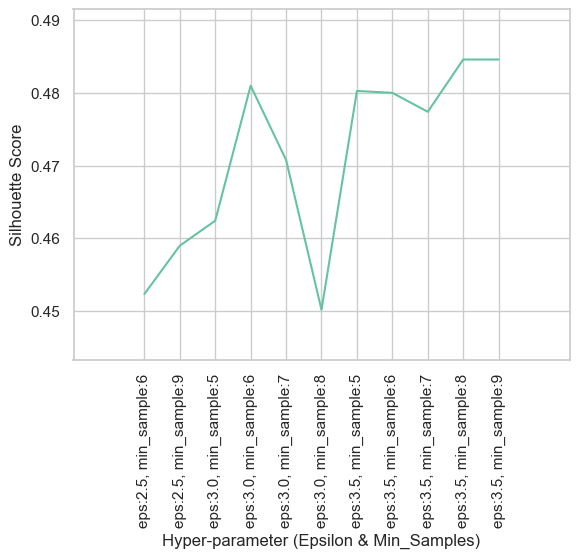

In [303]:
fig, ax = plt.subplots()
sns.lineplot(x="parameters", y="score", data=silhouette_scores_data[silhouette_scores_data["score"] > 0.45].reset_index())  
ax.set(xlabel='Hyper-parameter (Epsilon & Min_Samples)', ylabel='Silhouette Score')
plt.xticks(rotation='vertical')
# Pad margins so that markers don't get clipped by the axes
plt.margins(0.2)
# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom=0.15)
plt.show()

A larger epsilon will produce broader clusters (encompassing more data points) and a smaller epsilon will build smaller clusters. In general, we prefer smaller values because we only want a small fraction of data points within the epsilon distance from each other. Therefore, epsilon=3.5 and min_samples = 8 hyper-parameters give us the best silhouette score and, hence, the best DBSCAN model.

### Final results for DBSCAN

[Text(0.5, 1.0, 'Final DBSCAN Clustering Plot')]

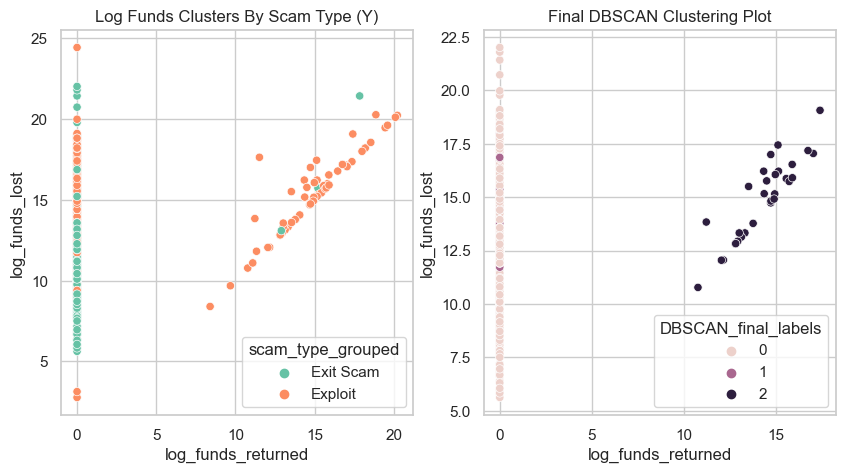

In [304]:
model = DBSCAN(eps=3.5, min_samples=8) # best hyper-parameter values
model.fit(X)
y_pred = model.fit_predict(X)
labels_DB = model.labels_

df['DBSCAN_final_labels'] = labels_DB

fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.scatterplot(x="log_funds_returned", y="log_funds_lost", hue="scam_type_grouped", data=df, ax=ax[0]).set(title='Log Funds Clusters By Scam Type (Y)')
sns.scatterplot(x="log_funds_returned", y="log_funds_lost", hue="DBSCAN_final_labels", data=df[df['DBSCAN_final_labels'] != -1], ax=ax[1]).set(title='Final DBSCAN Clustering Plot') # removing label = -1 because it corresponds to noise

In [305]:
# Number of clusters in labels, ignoring noise if present.
import sklearn.metrics as metrics
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score
n_clusters_ = len(set(labels_DB)) - (1 if -1 in labels_DB else 0)
n_noise_ = list(labels_DB).count(-1)
labels_true = y

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels_DB))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels_DB))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels_DB))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels_DB))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true, labels_DB)
)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels_DB))

Estimated number of clusters: 3
Estimated number of noise points: 43
Homogeneity: 0.081
Completeness: 0.086
V-measure: 0.083
Adjusted Rand Index: 0.010
Adjusted Mutual Information: 0.081
Silhouette Coefficient: 0.485


# Agglomerative Clustering (Hierarchical clustering)

In [278]:
# Perform Agglomerative Clustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=3, affinity='euclidean',linkage='ward').fit(X)
labels = model.labels_

 ### Plot the clusters for Agglomerative Clustering

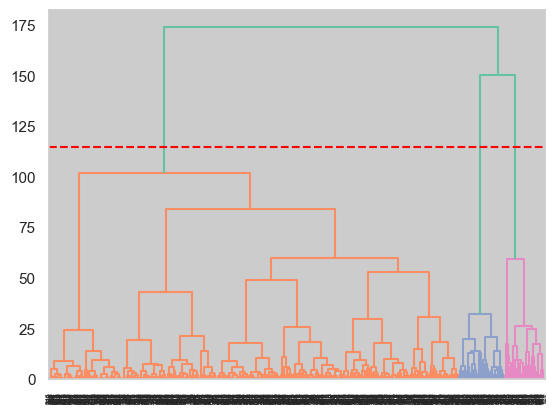

In [279]:
# create linkage for agglomerative clustering, and the dendrogram for the linkage. 

Z = linkage(X, method='ward') # linkage computed using euclidean distance  
dend = dendrogram(Z)
plt.axhline(y=115, color='r', linestyle='--', label='115')

From the above dendrogram, we set a threshold at value 115, which cuts through the dendrogram three times. This means we get three clusters.

### Hyper-parameter tuning

In [280]:
# THIS WILL ITERATE OVER ONE HYPER-PARAMETER (GRID SEARCH) 
# AND RETURN THE CLUSTER RESULT THAT OPTIMIZES THE SILHOUETTE SCORE
def maximize_silhouette(X,algo="birch",nmax=20,i_plot=False):

    # PARAM
    i_print=False

    #FORCE CONTIGUOUS
    X=np.ascontiguousarray(X) 

    # LOOP OVER HYPER-PARAM
    params=[]; sil_scores=[]
    sil_max=-10
    for param in range(2,nmax+1):

        if(algo=="ag"):
            model = sklearn.cluster.AgglomerativeClustering(n_clusters=param, affinity="cosine", linkage='single').fit(X)
            labels=model.labels_

        try:
            sil_scores.append(sklearn.metrics.silhouette_score(X,labels))
            params.append(param)
        except:
            continue 

        if(i_print): print(param,sil_scores[-1])
        
        if(sil_scores[-1]>sil_max):
             opt_param=param
             sil_max=sil_scores[-1]
             opt_labels=labels

    print("OPTIMAL PARAMETER =",opt_param)

    if(i_plot):
        fig, ax = plt.subplots()
        ax.plot(params, sil_scores, "-o")  
        ax.set(xlabel='N_Clusters', ylabel='Silhouette Score')
        plt.show()

    return opt_labels

In [281]:
def plot(X,color_vector):
    fig, [ax1, ax2] = plt.subplots(1,2, figsize=(10,5))
    sns.scatterplot(df["log_funds_returned"], df["log_funds_lost"], hue=df["scam_type_grouped"], ax=ax1)
    ax1.set(xlabel='log_funds_returned', ylabel='log_funds_lost',
    title='Log Funds Clusters By Scam Type (Y)')
    ax1.grid()
    scatter2 = ax2.scatter(X['log_funds_returned'], X['log_funds_lost'],c=color_vector, alpha=0.5) 
    ax2.set(xlabel='log_funds_returned', ylabel='log_funds_lost',
    title='Agglomerative Clustering Plot')
    legend2 = ax2.legend(*scatter2.legend_elements(),
                    loc="lower right", title="Clusters")
    ax2.add_artist(legend2)
    ax2.grid()
    plt.show()

#### Single-linkage Agglomerative Clustering

OPTIMAL PARAMETER = 2


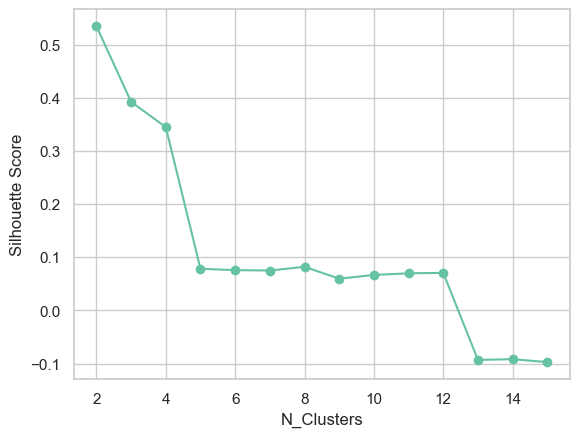

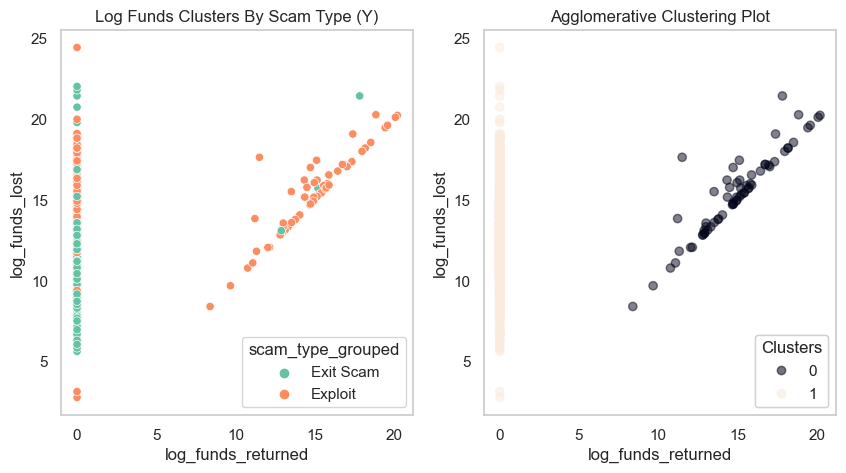

In [282]:
opt_labels=maximize_silhouette(X,algo="ag",nmax=15, i_plot=True)
plot(X,opt_labels)

Single-linkage uses the minimum of the distances between all observations of the two sets. For the above model, we also chose the affinity hyper-parameter, a metric used to compute the linkages, as cosine and found that the best number of clusters is two, as shown above in the first plot.

#### Complete-linkage Agglomerative Clustering

In [283]:
# THIS WILL ITERATE OVER ONE HYPER-PARAMETER (GRID SEARCH) 
# AND RETURN THE CLUSTER RESULT THAT OPTIMIZES THE SILHOUETTE SCORE
def maximize_silhouette(X,algo="birch",nmax=20,i_plot=False):

    # PARAM
    i_print=False

    #FORCE CONTIGUOUS
    X=np.ascontiguousarray(X) 

    # LOOP OVER HYPER-PARAM
    params=[]; sil_scores=[]
    sil_max=-10
    for param in range(2,nmax+1):

        if(algo=="ag"):
            model = sklearn.cluster.AgglomerativeClustering(n_clusters=param, affinity="manhattan", linkage='complete').fit(X)
            labels=model.labels_

        try:
            sil_scores.append(sklearn.metrics.silhouette_score(X,labels))
            params.append(param)
        except:
            continue 

        if(i_print): print(param,sil_scores[-1])
        
        if(sil_scores[-1]>sil_max):
             opt_param=param
             sil_max=sil_scores[-1]
             opt_labels=labels

    print("OPTIMAL PARAMETER =",opt_param)

    if(i_plot):
        fig, ax = plt.subplots()
        ax.plot(params, sil_scores, "-o")  
        ax.set(xlabel='N_Clusters', ylabel='Silhouette Score')
        plt.show()

    return opt_labels

OPTIMAL PARAMETER = 3


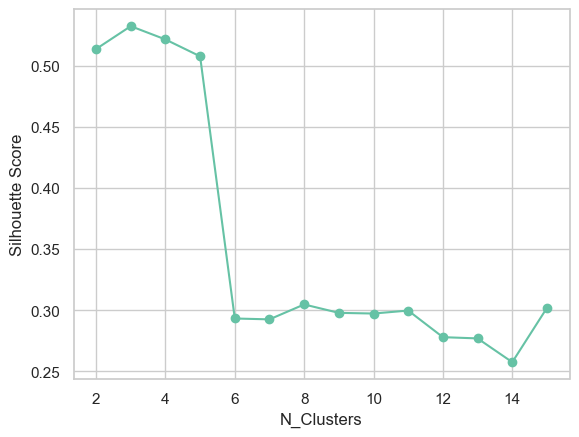

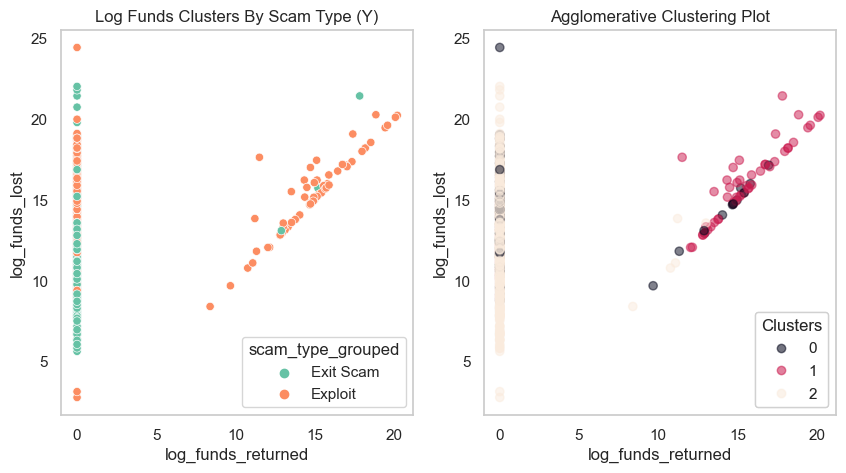

In [284]:
opt_labels=maximize_silhouette(X,algo="ag",nmax=15, i_plot=True)
plot(X,opt_labels)

Complete-linkage uses the maximum distances between all observations of the two sets. For the above model, we also chose the affinity hyper-parameter, a metric used to compute the linkages, as manhattan and found that the best number of clusters is three, as shown above in the first plot. Therefore, given the plots of two different hyper-parameter tuned models, the single-linkage hierarchical clustering model performs better in clustering, as the clustering predictions better coincide with the existing labels (scam_type_grouped) in the data-set.

### Final results for Agglomerative Clustering

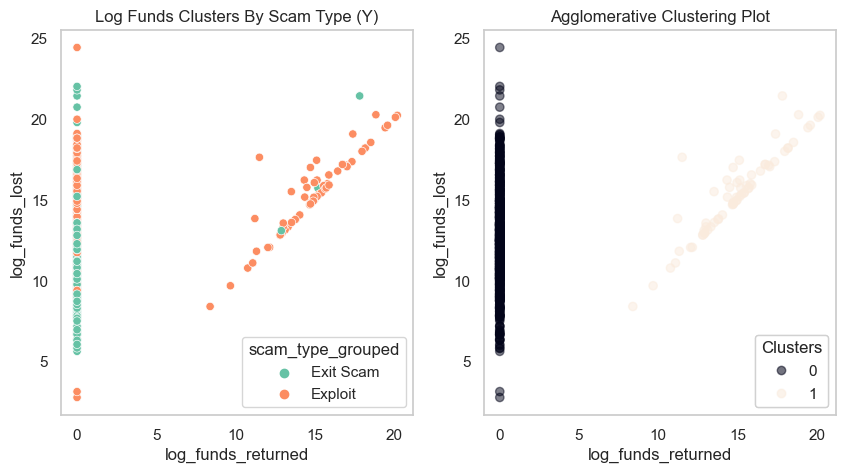

In [285]:
final_model = AgglomerativeClustering(n_clusters=2, linkage='single').fit(X)
final_labels = final_model.labels_
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(10,5))
sns.scatterplot(df["log_funds_returned"], df["log_funds_lost"], hue=df["scam_type_grouped"], ax=ax1)
ax1.set(xlabel='log_funds_returned', ylabel='log_funds_lost',
title='Log Funds Clusters By Scam Type (Y)')
ax1.grid()
scatter2 = ax2.scatter(X['log_funds_returned'], X['log_funds_lost'],c=final_labels, alpha=0.5) 
ax2.set(xlabel='log_funds_returned', ylabel='log_funds_lost',
title='Agglomerative Clustering Plot')
legend2 = ax2.legend(*scatter2.legend_elements(),
                loc="lower right", title="Clusters")
ax2.add_artist(legend2)
ax2.grid()
plt.show()

# Results

We performed clustering using three different models, including K-Means, DBSCAN, and Agglomerative Clustering. The final result of the K-Means model was based off on the outputs of both the silhouette score and the elbow method. The elbow method conveyed that k=4 clusters would be optimum, but the silhouette score for k=4 was 0.35, lower than that of k=5 that had a silhouette score of approximately 0.53. 

In fact, the final model for K-Means outputs the best clusters out of all other models in relation to the scam_type_grouped (Y) labels in the data set. The labels and clusters coincide the best out of all other models, as one cluster is dedicated to those observations that have a positive log_funds_returned and so are the Exploit scam type labels. Moreover, only K-Means clusters depict the behavior of correctly clustering those points that have 0 log_funds_returned but positive log_funds_lost into two clusters. If we look at the scatterplot for scam_type_grouped labels, we see that Exit Scams have lower log_funds_lost (green cluster) and Exploit scams have higher log_funds_lost (orange cluster) when log_funds_returned is 0. This characteristic is best captured by the final K-Means model, as label 2 (deep purple) clusters are similar to the Exit Scams (green cluster) and label 0 (pink) clusters are similar to the Exploit scams (orange cluster) when log_funds_returned is 0. 

The DBSCAN model had the best improvement out of all models from its initial model to the final model, which did output three clusters, like K-Means did, but did not capture the relation of the scam_type_grouped (Y) labels. This could be because when one looks at the scatterplot of log_funds_returned vs log_funds_lost, he or she can conclude with the naked eye that there exist two clusters only, points where log_funds_returned is 0 and points where log_funds_returned and log_funds_lost are both positive. Therefore, because these clusters seem linearly separable, they can easily be clustered with a simpler algorithm, like K-Means. Moreover, our log transformed numeric features had almost no outliers present due to the transformation, but DBSCAN detected some noise points around the cluster that had positive values for log_funds_returned and log_funds_lost. Therefore, if our data was more complex, perhaps with non-globular clusters and clusters of different sizes, DBSCAN could have performed better than K-Means.

Finally, Agglomerative/Hierarchical clustering did a better job of clustering the feature data (X) than DBSCAN but not as good as K-Means. The initial model was powerful because it outputted three clusters and, upon hyper-parameter tuning, the final model was as good as the initial model. The reason why complete-linkage hyper-parameter model was not chosen as the final model was because it contained overlapping clusters for points that had positive log_funds_returned and log_funds_lost values. The single-linkage model, on the other hand, separated the positive log_funds_returned points from the points that had log_funds_returned = 0, leading to two distinct clusters. However, unlike K-Means, the single-linkage model could not capture cluster associations for points that had log_funds_returned = 0. 

# Conclusions

To wrap up, we found that the K-Means model clustered the feature dataset (X) most aptly in relation to the target variable (Y), scam_type_grouped, of the dataset. DBSCAN performed the worst and Hierarchical clustering performed second best. The primary finding from our results was that the right clustering model can help extract the ground truths (or labels) from only the feature dataset. Therefore, although simple and easy to execute, clustering models can be highly powerful in generating accurate insights of the overall data from independent features only. It would have helped my modeling process if I had more numeric features attached to the dataset, which would have probably led to not only more clusters being formed but also clusters of different shapes and sizes/densities. For example, an additional numeric feature not related to funds would have added to the complexity of the dataset and, hence, comparing the clusters with those of the labelled (Y) clusters may have yielded different results. Moreover, we could have visualized the data in 3-D, using the three numeric features, and, as a result, added a new perspective to the dataset.

# References

Santini, Marina. “Advantages*&amp;*Disadvantages*of** k:Means*and*Hierarchical ... - Santini.” Accessed November 8, 2022. http://santini.se/teaching/ml/2016/Lect_10/10c_UnsupervisedMethods.pdf. 

“Clustering Analysis - Computer Science | Western Michigan University.” Accessed November 10, 2022. https://cs.wmich.edu/alfuqaha/summer14/cs6530/lectures/ClusteringAnalysis.pdf. 

Ajitesh  Kumar. “Elbow Method vs Silhouette Score - Which Is Better?” Data Analytics, November 28, 2021. https://vitalflux.com/elbow-method-silhouette-score-which-better/#:~:text=The%20elbow%20method%20is%20used,cluster%20or%20across%20different%20clusters. 

Bock, Tim. “What Is a Dendrogram?” Displayr, September 13, 2022. https://www.displayr.com/what-is-dendrogram/. 

“Demo of DBSCAN Clustering Algorithm.” scikit. Accessed November 9, 2022. https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html. 

Hashmi, Farukh. “How to Create Clusters Using DBSCAN in Python.” Thinking Neuron, November 27, 2021. https://thinkingneuron.com/how-to-create-clusters-using-dbscan-in-python/. 